## Importing Libraries:

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt

import warnings
import time
import pickle
import json

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, roc_auc_score, fbeta_score, accuracy_score, \
                            classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, \
                            precision_recall_curve, mean_squared_error, r2_score, make_scorer

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder
from scipy.stats import randint, uniform

## Importing Data:

In [30]:
route = "../Data/Preprocessed_Data.csv"

df_data_0 = pd.read_csv(route).drop("Unnamed: 0", axis = 1)
df_data_0.shape

(120000, 20)

In [31]:
df_data = df_data_0.copy()
df_data.head()

,Proj_Group,Proj_Segment,Proj_Type,Visitor_Group,Visitor_Gender,Question_Age,Question_Budget,Question_HHIncome,Question_InstallmentMonthly,Question_MarriageStatus,Question_Nationality,Question_Occupation,Question_P_Income,Question_TimeToMoveIn,Target_Variable_Convert,Question_Property_Buy_Objective,Question_Channel,Question_Factors_Considered,Question_Reason_to_visit_property_fair,Question_CashInstallmentOrNot
0,Outer,B,Standard Units,Central,F,51 +,11.300000,587981.300000,81492.85000,Single,NaN,Business Owner,135377.055709,9.104913,False,Residence,NaN,Near_ShoppingMall,Company,Not_Cash
1,Outer,A,Standard Units,Outer,M,46 - 50,13.500000,421363.000000,54873.47601,Married with Children,NaN,Other(Please specify),160000.000000,9.104913,False,NaN,Billboard,NaN,Location,NaN
2,Central,B,Premium Units,Central,F,51 +,11.300000,285742.151827,54873.47601,NaN,India,NaN,135377.055709,9.104913,False,Residence,Billboard,NaN,Location,NaN
3,Urban,A,Standard Units,Central,M,51 +,7.706004,285742.151827,54873.47601,Married with Children,NaN,Business Owner,135377.055709,9.104913,False,Residence,Billboard,NaN,Location,NaN
4,Outer,A,Standard Units,Central,M,51 +,16.000000,587981.300000,81492.85000,Married with Children,NaN,Business Owner,135377.055709,9.104913,False,Residence,NaN,Near_Previous_Home,Project_s_Attractiveness,Not_Cash


In [32]:
# Setting numeric and categorical variables to their correct types
numeric_var = ["Question_Budget", "Question_HHIncome", "Question_P_Income", "Question_TimeToMoveIn", 
               "Question_InstallmentMonthly"]

categorical_var = []

for i in df_data.columns:
    if i not in numeric_var:
        categorical_var.append(i)
        
for i in df_data.columns:
    if i in numeric_var:
        df_data[i] = df_data[i].astype(float)
    else:
        df_data[i] = df_data[i].astype("object")

## Question 4 - Class Imbalance in Target Variable:

In [33]:
target_count = df_data["Target_Variable_Convert"].value_counts().to_frame("Quantity").reset_index()

target_percent = df_data["Target_Variable_Convert"].value_counts(normalize = True).mul(100).to_frame("Percentage").reset_index()

target = pd.merge(target_count, target_percent, on = "index", how = "inner")
target

,index,Quantity,Percentage
0,False,111245,92.704167
1,True,8755,7.295833


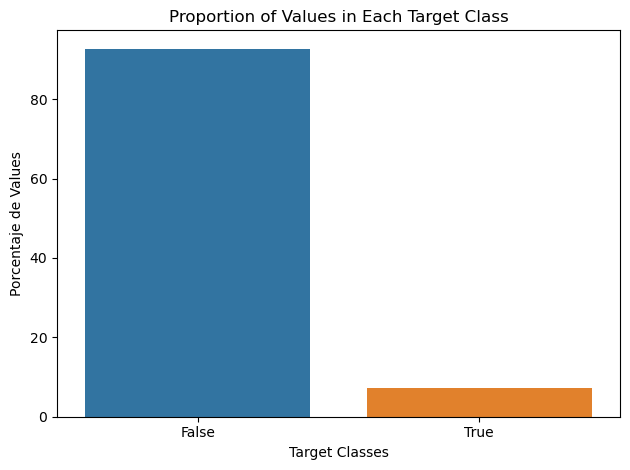

In [34]:
sns.barplot(x = "index", y = "Percentage", data = target)

plt.title("Proportion of Values in Each Target Class")
plt.ylabel("Porcentaje de Values")
plt.xlabel("Target Classes")

plt.tight_layout()

When analysing the diagram seen above, we can clearly see that there is a significant imbalance problem with regards to the binomial target variable's two target classes of False (Class 0) and True (Class 1). This will prove to be an extremely limiting factor for the model's prediction capability of Class 1 instances if left untreated. As a result, the most reasonable set of steps that should be taken are to either undersample the Class 0 instances or oversample the Class 1 instances until the number of instances are relatively equal for both target classes. In the case of this project, I have chosen to use the oversampling technique using the SMOTE algorithm for the "imblearn" python library.

In [35]:
# Organising the dataset in such a way that the numeric variables appear first and are followed by the categorical
# variables, this is a completely optional personal preference that helps me visualise what I'm doing as I code
df_data = pd.concat([df_data[numeric_var], df_data[categorical_var]], axis = 1)

# Separating the dataset into a training and testing set of data
X = df_data.drop("Target_Variable_Convert", axis = 1)
Y = df_data.Target_Variable_Convert.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [36]:
# Creating a separate list of categorical variables that will not include the target variable itself
no_target_categorical_var = []

for i in categorical_var:
    if i != "Target_Variable_Convert":
        no_target_categorical_var.append(i)

In [37]:
# Creating the transformers and pipelines that will be used to treat the data before training the model. This involves a 
# process that first standardises the numeric variables in order to simplify the model's training, then proceeds to encode
# the categorical variables using the One-Hot Encoding algorithm (other algorithms like Target Encoding would also have
# worked), and finally oversamples the instances of the target variable's "Class 1" for the imbalanced problem mentioned
# above to be solved.

numeric_transformer = Pipeline(steps = [("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps = [("te", TargetEncoder())])

preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, numeric_var), 
                                                 ("cat", categorical_transformer, no_target_categorical_var)])

oversampling_pipeline = ImbPipeline(steps = [("preprocessor", preprocessor), ("smote", SMOTE(random_state = 42))])

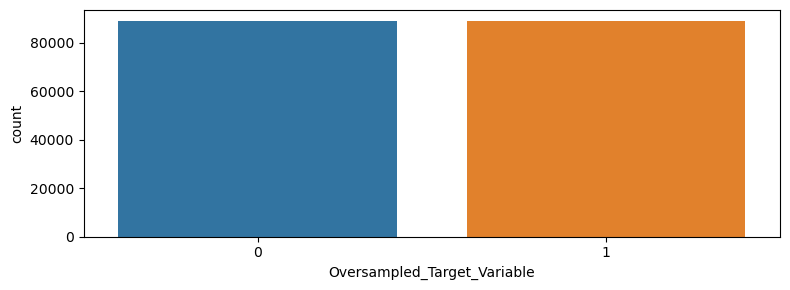

In [38]:
# We can see from the diagram below that the imbalanced issue that used to be taking place is no longer influencing the 
# training of the classification model. It's extremely important to mention that the oversampling must not be implemented
# onto the testing dataset of the model as that dataset must be left completely intact throughout the whole model
# development process (otherwise, the risk of causing overfitting would be significantly increased).
X_train_oversampled, y_train_oversampled = oversampling_pipeline.fit_resample(X_train, y_train)

oversampled_data_diagram = pd.DataFrame({"Oversampled_Target_Variable": y_train_oversampled})
f, (ax) = plt.subplots(figsize = (8, 3))
ax = sns.countplot(data = oversampled_data_diagram, x = "Oversampled_Target_Variable")
plt.tight_layout()

## Question 5 - Training The Classification Model:
### Classification Model Algorithm Selection:

In [39]:
# Creating a list of the three classifier algorithms that will be compared in order to select one (the list is created in
# order to automate the process)
classifiers = [RandomForestClassifier(random_state = 42),
               AdaBoostClassifier(random_state = 42),
               GradientBoostingClassifier(random_state = 42)]

classifier_names = ["Random Forest Classifier", "Ada Boost Classifier", "Gradient Boosting Classifier", ]

In [40]:
# An empty dataframe is created for future ease in comparing the results of the three classifier algorithms being compared
df_results = pd.DataFrame({"Classification Model": [], 
                             "Accuracy": [],
                             "F2 Score": [],
                             "Recall": [],
                             "Precision": [],
                             "Time Taken (min)": []})

df_base_results = df_results.copy()

In [41]:
# The three classifier algorithms are trained on the training dataset without any fine-tuning or variable selection seeing
# as, at the moment, we are only comparing their results with each other in order to select one that will be further 
# improved further on in the notebook.
n = 0

for classifier in classifiers:
    start_time = time.time()

    classifier.fit(X_train_oversampled, y_train_oversampled)
    
    X_test_preprocessed = preprocessor.transform(X_test)
    y_pred = classifier.predict(X_test_preprocessed)

    end_time = time.time()
    elapsed_time = end_time - start_time
    
    accuracy = accuracy_score(y_test, y_pred)
    f2 = fbeta_score(y_true = y_test, y_pred = y_pred, beta = 2)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    df_base_results.loc[n] = [classifier_names[n], round(accuracy, 3), round(f2, 3), round(recall, 3), round(precision, 3),
                              round((elapsed_time / 60), 3)]
    
    n += 1
    
df_base_results

,Classification Model,Accuracy,F2 Score,Recall,Precision,Time Taken (min)
0,Random Forest Classifier,0.935,0.432,0.405,0.586,1.195
1,Ada Boost Classifier,0.900,0.458,0.490,0.365,0.441
2,Gradient Boosting Classifier,0.918,0.440,0.440,0.443,1.909


The table above demontrates the different performances of the three classifiers being compared. We can see that they are each best in their own way. The Ada Boost Classifier is best when looking at the accuracy metric, which measures the amount of instances predicted correctly in total. On the other hand, the Ada Boost Classifier is best when looking at the recall metric, which measures how many of the "Class 1" instances were predicted correctly, whereas the Gradient Boosting Classifier is best when looking at the F2 Score metric (a metric that combines both Recall and Precision scores in such a way that it favours the correct predictions of "Class 1" instances of the target variable). For the purpose of this project, I chose to use the Ada Boost Classifier seeing as it had a higher accuracy rating than the other two classifiers and seeing as the other two had relatively low precision scores (meaning that the large majority of the instances predicted as "Class 1" were incorrectly classified as such).

### Variable Reduction:

In [42]:
ab_clf = classifiers[1]
ab_clf.fit(X_train_oversampled, y_train_oversampled)

AdaBoostClassifier(random_state=42)

In [43]:
# Obtaining the relative importances of the variables in terms of the contribution they offered for the model's predictions
feature_importance = ab_clf.feature_importances_
all_var = list(df_data.drop("Target_Variable_Convert", axis = 1).columns)

importance_df = pd.DataFrame({"Feature": all_var, 
                              "Importance": feature_importance})
importance_df.head()

,Feature,Importance
0,Question_Budget,0.0
1,Question_HHIncome,0.0
2,Question_P_Income,0.0
3,Question_TimeToMoveIn,0.0
4,Question_InstallmentMonthly,0.0


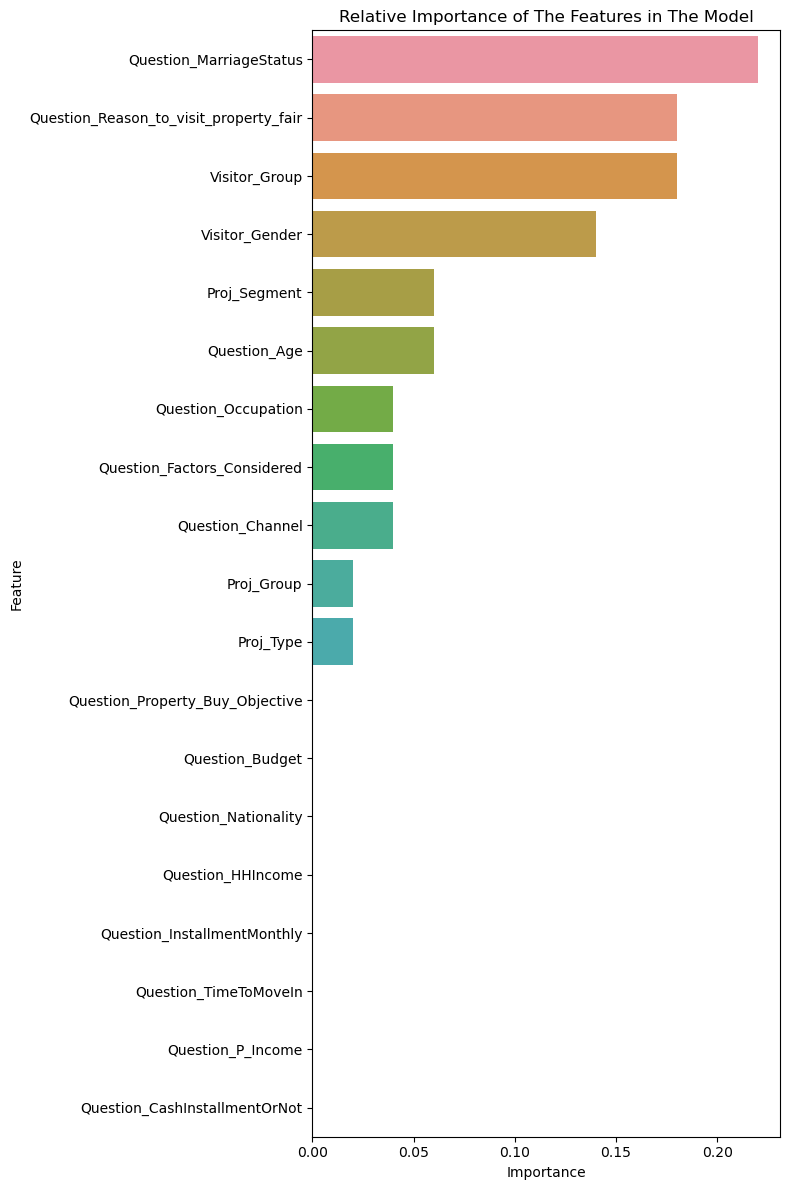

In [44]:
# Illustrating teh relative importance of all the variables visually
importance_df = importance_df.sort_values(by = "Importance", ascending = False)

f, (ax) = plt.subplots(figsize = (8, 12))
sns.barplot(x = "Importance", y = "Feature", data = importance_df, ax = ax)
ax.set_title("Relative Importance of The Features in The Model")
plt.tight_layout()

In [45]:
# We will reduce the dimensionality of the dataset by eliminating the variables that did not contribute any relevant
# information
eliminated_var = list(importance_df["Feature"][importance_df["Importance"] == 0])
eliminated_var

['Question_Property_Buy_Objective',
 'Question_Budget',
 'Question_Nationality',
 'Question_HHIncome',
 'Question_InstallmentMonthly',
 'Question_TimeToMoveIn',
 'Question_P_Income',
 'Question_CashInstallmentOrNot']

In [18]:
final_numeric_var = []
final_categorical_var = []

for i in numeric_var:
    if i not in eliminated_var:
        final_numeric_var.append(i)
        
for i in no_target_categorical_var:
    if i not in eliminated_var:
        final_categorical_var.append(i)

In [19]:
# We re-creaete the preprocessing and oversampling pipelines without the insignificant variables seen above
preprocessor = ColumnTransformer(transformers = [("num", numeric_transformer, final_numeric_var), 
                                                 ("cat", categorical_transformer, final_categorical_var)])

oversampling_pipeline = ImbPipeline(steps = [("preprocessor", preprocessor), ("smote", SMOTE(random_state = 42))])

X_train_oversampled_reduced, y_train_oversampled = oversampling_pipeline\
                                                    .fit_resample(X_train.drop(eliminated_var, axis = 1), y_train)

ab_clf_1 = classifiers[1]
ab_clf_1.fit(X_train_oversampled_reduced, y_train_oversampled)

X_test_preprocessed = preprocessor.transform(X_test.drop(eliminated_var, axis = 1))
y_pred = ab_clf_1.predict(X_test_preprocessed)

print(f"Accuracy : {round(accuracy_score(y_test, y_pred), 3)}")
print(f"F2 Score : {round(fbeta_score(y_true = y_test, y_pred = y_pred, beta = 2), 3)}")
print(f"Recall Score : {round(recall_score(y_test, y_pred), 3)}")
print(f"Precision Score : {round(precision_score(y_test, y_pred), 3)}")

Accuracy : 0.859
F2 Score : 0.52
Recall Score : 0.647
Precision Score : 0.291


Above, are the results from the Ada Boost Classifier trained on the reduced dataset with the default hyperparameters. We can already see that all three metrics improved slightly after eliminating the variables that were not contributing any relevant information.t were not contributing any relevant information.

### Hyperparameter Fine-Tuning:

In [20]:
start_time = time.time()

# These are the parameters of the Ada Boost Classifier that I will be fine-tuning:
parameters = {"n_estimators": randint(50, 300),
              "learning_rate": uniform(0.01, 1),
              "algorithm": ["SAMME"],
              "random_state": [42]
             }

# This is the the scoring system that the fine-tuning function ("RandomizedSearchCV()") will be using to optimise the 
# hyperparameters of the parameters seen above:
f2_scorer = make_scorer(fbeta_score, beta = 2)

opt_clf = RandomizedSearchCV(ab_clf_1, param_distributions = parameters, n_iter = 20, cv = 5, n_jobs = -1, 
                             random_state = 42, scoring = f2_scorer)

# Fit the model on the training data
opt_clf.fit(X_train_oversampled_reduced, y_train_oversampled)

end_time = time.time()
elapsed_time = end_time - start_time

# Extract the best hyperparameters
hyperparam = opt_clf.best_params_
print("Best hyperparameters:", hyperparam)

# Best F2 score during cross-validation
best_accuracy_score = opt_clf.best_score_
print("Best F2 Score: ", best_f2_score)

print(f"Elapsed time: {elapsed_time / 60} minutes")

Best hyperparameters: {'algorithm': 'SAMME', 'learning_rate': 0.9932308858067882, 'n_estimators': 298, 'random_state': 42}
Best F2 Score:  0.89217039691107
Elapsed time: 11.956954797108969 minutes


In [21]:
best_clf = opt_clf.best_estimator_

# Preprocess and predict on the test set
y_pred = best_clf.predict(X_test_preprocessed)

f2_test = fbeta_score(y_test, y_pred, beta=2)
print(f"F2 score on the test set: {f2_test}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

F2 score on the test set: 0.5117565698478561
Confusion Matrix:
[[20188  2054]
 [  722  1036]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94     22242
           1       0.34      0.59      0.43      1758

    accuracy                           0.88     24000
   macro avg       0.65      0.75      0.68     24000
weighted avg       0.92      0.88      0.90     24000



### Training of Final Version of Model:

In [22]:
start_time = time.time()

# The final version of the classification model using the hyperparameters found by the fine-tuning process above.
final_clf = AdaBoostClassifier(**hyperparam)

final_clf.fit(X_train_oversampled_reduced, y_train_oversampled)

X_test_preprocessed = preprocessor.transform(X_test.drop(eliminated_var, axis = 1))
y_pred = final_clf.predict(X_test_preprocessed)

end_time = time.time()
elapsed_time = end_time - start_time

accuracy_final = accuracy_score(y_test, y_pred)
f2_final = fbeta_score(y_true = y_test, y_pred = y_pred, beta = 2)
recall_final = recall_score(y_test, y_pred)
precision_final = precision_score(y_test, y_pred)

df_results.loc[1] = ["Final Ada Boost Model", round(accuracy_final, 3), round(f2_final, 3), round(recall_final, 3), 
                     round(precision_final, 3), round((elapsed_time / 60), 3)]

print("Final Ada Boost Classifier Model Results:")
print("")
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print("")

print(f"Elapsed time: {round((elapsed_time / 60), 2)} minutes")

df_results

Final Ada Boost Classifier Model Results:

Confusion Matrix:
[[20188  2054]
 [  722  1036]]

Elapsed time: 0.52 minutes


,Classification Model,Accuracy,F2 Score,Recall,Precision,Time Taken (min)
1,Final Ada Boost Model,0.884,0.512,0.589,0.335,0.519


### Exporting The Model for Further Analysis in The Next Notebook:

In [23]:
# Creating the excel file with different sheets as requested
test_series = pd.Series(y_test, name = "Actual Results (y_test)")
pred_series = pd.Series(y_pred, name = "Predicted Results (y_pred)")

with pd.ExcelWriter("Classification_Model_Results.xlsx") as writer:
    test_series.to_frame().to_excel(writer, sheet_name = "Actual Results (y_test)", index = False)
    pred_series.to_frame().to_excel(writer, sheet_name = "Predicted Results (y_pred)", index = False)

In [24]:
with open("../Models/Ada_Boost_Model.pkl", "wb") as ada_boost_model:
    pickle.dump(final_clf, ada_boost_model)

In [46]:
# Exporting the numpy array of the transformed X_test dataset for the analysis of different metrics in the third notebook
np.save("../Data/Transformed_X_test.npy", X_test_preprocessed)

# Exporting the list of feature names for ease in their implementation in the third notebook
feature_names = []
for i in all_var:
    if i not in eliminated_var:
        feature_names.append(i)
        
with open("../Data/feature_names.json", 'w') as f:
    json.dump(feature_names, f)

# Exporting the pandas series of the y_test dataset in order to determine the probabilities with which each of the model's
# predictions were made (process done in the third notebook)
y_test.to_csv("../Data/y_test.csv", index = True)

In [26]:
# Visualising the first 10 instances of the y_test dataset
y_test[:10]

71787     0
67218     0
54066     0
7168      0
29618     0
101425    0
20441     0
2662      0
20371     0
108151    0
Name: Target_Variable_Convert, dtype: int32